In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterio.mask import mask
from shapely.geometry import Point

In [3]:
base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_ndvi = os.path.join(base, "NDVI_2023_32618_30m.tif")
path_ndbi = os.path.join(base, "ndbi_reproyectado.tif")
path_lst  = os.path.join(base, "LST_2023_Reproyectado.tif")
path_stations = "/content/drive/MyDrive/..."


In [4]:
!pip install rasterio

D1. Datos de entrada y marco temporal

In [5]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.ndimage import distance_transform_edt, convolve
import matplotlib.pyplot as plt

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_urb_2020   = os.path.join(base, "worldcover_2020_BUILTUP_30m.tif")
path_urb_2023   = os.path.join(base, "urbano_UNet_2023.tif")
path_ndvi_2023  = os.path.join(base, "NDVI_2023_32618_30m.tif")
path_ndbi_2023  = os.path.join(base, "ndbi_reproyectado.tif")

out_suitability     = os.path.join(base, "suitability_urbana_2023.tif")
out_urb_2030_base   = os.path.join(base, "urbano_CA_Markov_2030_base.tif")
out_urb_2030_acel   = os.path.join(base, "urbano_CA_Markov_2030_acelerado.tif")
out_urb_2030_mitig  = os.path.join(base, "urbano_CA_Markov_2030_mitigacion.tif")


def load_raster(path):
    src = rasterio.open(path)
    arr = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        arr[arr == nodata] = np.nan
    return src, arr

def reproject_to_match(src_in, arr_in, src_ref, resampling=Resampling.nearest):
    dst_arr = np.full((src_ref.height, src_ref.width), np.nan, dtype=np.float32)
    reproject(
        source=arr_in,
        destination=dst_arr,
        src_transform=src_in.transform,
        src_crs=src_in.crs,
        dst_transform=src_ref.transform,
        dst_crs=src_ref.crs,
        resampling=resampling
    )
    return dst_arr

def binarize_urban(arr, threshold=0.5):
    """Convierte un raster en 0/1. Si ya es 0/1, lo respeta."""
    valid = ~np.isnan(arr)
    out = np.zeros_like(arr, dtype=np.uint8)
    uniques = np.unique(arr[valid])
    if set(uniques).issubset({0, 1}):
        out[valid] = arr[valid].astype(np.uint8)
    else:
        out[valid] = (arr[valid] > threshold).astype(np.uint8)
    return out

def minmax_norm(arr, mask):
    """Normalización min-max sobre los píxeles True en mask."""
    vals = arr[mask]
    out = np.zeros_like(arr, dtype=float)
    if vals.size == 0:
        return out
    vmin = np.nanmin(vals)
    vmax = np.nanmax(vals)
    if np.isclose(vmax, vmin):
        out[mask] = 0.5
    else:
        out[mask] = (arr[mask] - vmin) / (vmax - vmin)
    return out


Diagnóstico rápido de los mapas urbanos

In [7]:

src_u20, urb_2020_raw = load_raster(path_urb_2020)
src_u23, urb_2023_raw = load_raster(path_urb_2023)


if (urb_2020_raw.shape != urb_2023_raw.shape) or (src_u20.crs != src_u23.crs):
    urb_2020 = reproject_to_match(src_u20, urb_2020_raw, src_u23)
else:
    urb_2020 = urb_2020_raw.copy()

urb_2023 = urb_2023_raw.copy()


u20 = np.zeros_like(urb_2020_raw, dtype=np.uint8)
u20[urb_2020_raw == 1] = 1
u23 = np.zeros_like(urb_2023_raw, dtype=np.uint8)
u23[urb_2023_raw == 1] = 1

print("Valores únicos u23 (CA):", np.unique(u23))
U23 = np.sum(u23 == 1)
print("Área urbana 2023 (n° píxeles):", U23)

print("Valores únicos u20 (CA):", np.unique(u20))
U20 = np.sum(u20 == 1)
print("Área urbana 2020 (n° píxeles):", U20)

Valores únicos u23 (CA): [0 1]
Área urbana 2023 (n° píxeles): 122694
Valores únicos u20 (CA): [0 1]
Área urbana 2020 (n° píxeles): 549064


In [8]:
import rasterio

paths = [
    path_urb_2023,
    path_ndvi_2023,
    path_ndbi_2023
]

for p in paths:
    with rasterio.open(p) as src:
        print("----", os.path.basename(p))
        print("CRS:", src.crs)
        print("Shape:", src.height, src.width)
        print()


---- urbano_UNet_2023.tif
CRS: EPSG:32618
Shape: 2294 4209

---- NDVI_2023_32618_30m.tif
CRS: EPSG:32618
Shape: 2294 4209

---- ndbi_reproyectado.tif
CRS: EPSG:32618
Shape: 2294 4209



In [14]:
src_ndvi, ndvi_raw = load_raster(path_ndvi_2023)
src_ndbi, ndbi_raw = load_raster(path_ndbi_2023)

if (ndvi_raw.shape != u23.shape) or (src_ndvi.crs != src_u23.crs):
    ndvi = reproject_to_match(src_ndvi, ndvi_raw, src_u23, resampling=Resampling.bilinear)
else:
    ndvi = ndvi_raw.copy()

if (ndbi_raw.shape != u23.shape) or (src_ndbi.crs != src_u23.crs):
    ndbi = reproject_to_match(src_ndbi, ndbi_raw, src_u23, resampling=Resampling.bilinear)
else:
    ndbi = ndbi_raw.copy()

valid_cov = ~np.isnan(ndvi) & ~np.isnan(ndbi)

ndvi_norm = minmax_norm(ndvi, valid_cov)
ndbi_norm = minmax_norm(ndbi, valid_cov)

In [15]:

NDVI_suit = np.zeros_like(ndvi_norm)
NDVI_suit[valid_cov] = 1 - ndvi_norm[valid_cov]


NDBI_suit = np.zeros_like(ndbi_norm)
NDBI_suit[valid_cov] = ndbi_norm[valid_cov]


from scipy.ndimage import distance_transform_edt

nonurban_mask = (u23 == 0) & valid_cov
dist = distance_transform_edt(nonurban_mask)
dist_norm = minmax_norm(dist, valid_cov)
DIST_suit = np.zeros_like(dist_norm)
DIST_suit[valid_cov] = 1 - dist_norm[valid_cov]


from scipy.ndimage import convolve

kernel = np.ones((5, 5), dtype=float)
u23_f = u23.astype(float)
neighbors = convolve(u23_f, kernel, mode="constant", cval=0.0)
neighbors_frac = neighbors / kernel.sum()
NEIGH_suit = np.zeros_like(neighbors_frac)
NEIGH_suit[valid_cov] = neighbors_frac[valid_cov]


w_ndvi = 0.35
w_ndbi = 0.35
w_dist = 0.15
w_neig = 0.15

suit = np.zeros_like(ndvi, dtype=float)
suit[valid_cov] = (
    w_ndvi * NDVI_suit[valid_cov] +
    w_ndbi * NDBI_suit[valid_cov] +
    w_dist * DIST_suit[valid_cov] +
    w_neig * NEIGH_suit[valid_cov]
)

suit = minmax_norm(suit, valid_cov)
suit[u23 == 1] = 0.0

print("Rango idoneidad:", np.nanmin(suit[valid_cov]), np.nanmax(suit[valid_cov]))


Rango idoneidad: 0.0 0.9107819388812517


In [16]:

escenario_base_pct   = 0.20
escenario_acel_pct   = 0.35
escenario_mitig_pct  = 0.10

K_new_base  = int(round(U23 * escenario_base_pct))
K_new_acel  = int(round(U23 * escenario_acel_pct))
K_new_mitig = int(round(U23 * escenario_mitig_pct))

print("Urbano 2023:", U23)
print("Nuevos píxeles (base):", K_new_base)
print("Nuevos píxeles (acelerado):", K_new_acel)
print("Nuevos píxeles (mitigación):", K_new_mitig)


Urbano 2023: 122694
Nuevos píxeles (base): 24539
Nuevos píxeles (acelerado): 42943
Nuevos píxeles (mitigación): 12269


In [17]:
def asignar_nuevos(u_actual, suit_arr, K_new, valid_mask):
    urb_new = u_actual.copy()
    nonurb = (urb_new == 0) & valid_mask
    cand_indices = np.where(nonurb)
    n_cand = cand_indices[0].size

    if n_cand == 0 or K_new <= 0:
        return urb_new
    if K_new > n_cand:
        K_new = n_cand

    suit_cand = suit_arr[cand_indices]
    sorted_idx = np.argsort(-suit_cand)
    top_idx = sorted_idx[:K_new]

    rows_new = cand_indices[0][top_idx]
    cols_new = cand_indices[1][top_idx]
    urb_new[rows_new, cols_new] = 1
    return urb_new


In [18]:

urb_2030_base = asignar_nuevos(u23, suit, K_new_base,  valid_cov)
urb_2030_acel = asignar_nuevos(u23, suit, K_new_acel,  valid_cov)

suit_mitig = suit.copy()
suit_mitig[(ndvi_norm > 0.5) & valid_cov] *= 0.5

urb_2030_mitig = asignar_nuevos(u23, suit_mitig, K_new_mitig, valid_cov)


In [19]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.ndimage import distance_transform_edt, convolve
import matplotlib.pyplot as plt

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_urb_2020   = os.path.join(base, "worldcover_2020_BUILTUP_30m.tif")
path_urb_2023   = os.path.join(base, "urbano_UNet_2023.tif")
path_ndvi_2023  = os.path.join(base, "NDVI_2023_32618_30m.tif")
path_ndbi_2023  = os.path.join(base, "ndbi_reproyectado.tif")

out_suitability     = os.path.join(base, "suitability_urbana_2023.tif")
out_urb_2030_base   = os.path.join(base, "urbano_CA_Markov_2030_base.tif")
out_urb_2030_acel   = os.path.join(base, "urbano_CA_Markov_2030_acelerado.tif")
out_urb_2030_mitig  = os.path.join(base, "urbano_CA_Markov_2030_mitigacion.tif")


In [20]:
def load_raster(path):
    """Lee un raster en float y convierte nodata a NaN."""
    src = rasterio.open(path)
    arr = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        arr[arr == nodata] = np.nan
    return src, arr

def reproject_to_match(src_in, arr_in, src_ref, resampling=Resampling.nearest):
    """Reproyecta y ajusta un raster a la grilla de referencia."""
    dst_arr = np.full((src_ref.height, src_ref.width), np.nan, dtype=np.float32)
    reproject(
        source=arr_in,
        destination=dst_arr,
        src_transform=src_in.transform,
        src_crs=src_in.crs,
        dst_transform=src_ref.transform,
        dst_crs=src_ref.crs,
        resampling=resampling
    )
    return dst_arr

def binarize_urban(arr, threshold=0.5):
    """
    Convierte un raster a 0/1 para urbano.
    Si ya está en 0/1 lo respeta (ignorando NaN).
    """
    valid = ~np.isnan(arr)
    out = np.zeros_like(arr, dtype=np.uint8)
    uniques = np.unique(arr[valid])
    if set(uniques).issubset({0, 1}):
        out[valid] = arr[valid].astype(np.uint8)
    else:
        out[valid] = (arr[valid] > threshold).astype(np.uint8)
    return out

def minmax_norm(arr, mask):
    """Normalización min–max sobre arr usando solo los píxeles True en mask."""
    vals = arr[mask]
    out = np.zeros_like(arr, dtype=float)
    if vals.size == 0:
        return out
    vmin = np.nanmin(vals)
    vmax = np.nanmax(vals)
    if np.isclose(vmax, vmin):
        out[mask] = 0.5
    else:
        out[mask] = (arr[mask] - vmin) / (vmax - vmin)
    return out

def asignar_nuevos(u_actual, suit_arr, K_new, valid_mask):
    """
    Asigna K_new nuevos píxeles urbanos (1) sobre u_actual,
    eligiendo los píxeles no urbanos con mayor idoneidad.
    """
    urb_new = u_actual.copy()
    nonurb = (urb_new == 0) & valid_mask

    cand_indices = np.where(nonurb)
    n_cand = cand_indices[0].size

    if n_cand == 0 or K_new <= 0:
        return urb_new
    if K_new > n_cand:
        K_new = n_cand

    suit_cand = suit_arr[cand_indices]
    sorted_idx = np.argsort(-suit_cand)
    top_idx = sorted_idx[:K_new]

    rows_new = cand_indices[0][top_idx]
    cols_new = cand_indices[1][top_idx]
    urb_new[rows_new, cols_new] = 1
    return urb_new


Cargar mapas urbanos 2020 y 2023

In [21]:
src_u20, urb_2020_raw = load_raster(path_urb_2020)

src_u23, urb_2023_raw = load_raster(path_urb_2023)

if (urb_2020_raw.shape != urb_2023_raw.shape) or (src_u20.crs != src_u23.crs):
    urb_2020 = reproject_to_match(src_u20, urb_2020_raw, src_u23)
else:
    urb_2020 = urb_2020_raw.copy()

urb_2023 = urb_2023_raw.copy()

u20 = binarize_urban(urb_2020)

u23 = np.zeros_like(urb_2023, dtype=np.uint8)
u23[urb_2023 == 1] = 1

print("Valores únicos u20:", np.unique(u20[~np.isnan(urb_2020)]))
print("Valores únicos u23 (CA):", np.unique(u23))

U20 = np.sum(u20 == 1)
U23 = np.sum(u23 == 1)
print("Área urbana 2020 (n° píxeles):", U20)
print("Área urbana 2023 (n° píxeles):", U23)

# Perfiles de salida
profile_u23 = src_u23.profile.copy()
profile_float = profile_u23.copy()
profile_float.update(dtype=rasterio.float32, nodata=np.nan)

profile_uint8 = profile_u23.copy()
profile_uint8.update(dtype=rasterio.uint8, nodata=255)


Valores únicos u20: [0 1]
Valores únicos u23 (CA): [0 1]
Área urbana 2020 (n° píxeles): 549064
Área urbana 2023 (n° píxeles): 122694


Mapa de idoneidad espacial 2023

In [22]:

src_ndvi, ndvi_raw = load_raster(path_ndvi_2023)
src_ndbi, ndbi_raw = load_raster(path_ndbi_2023)

if (ndvi_raw.shape != u23.shape) or (src_ndvi.crs != src_u23.crs):
    ndvi = reproject_to_match(src_ndvi, ndvi_raw, src_u23, resampling=Resampling.bilinear)
else:
    ndvi = ndvi_raw.copy()

if (ndbi_raw.shape != u23.shape) or (src_ndbi.crs != src_u23.crs):
    ndbi = reproject_to_match(src_ndbi, ndbi_raw, src_u23, resampling=Resampling.bilinear)
else:
    ndbi = ndbi_raw.copy()

valid_cov = ~np.isnan(ndvi) & ~np.isnan(ndbi)

ndvi_norm = minmax_norm(ndvi, valid_cov)
ndbi_norm = minmax_norm(ndbi, valid_cov)


NDVI_suit = np.zeros_like(ndvi_norm)
NDVI_suit[valid_cov] = 1 - ndvi_norm[valid_cov]

NDBI_suit = np.zeros_like(ndbi_norm)
NDBI_suit[valid_cov] = ndbi_norm[valid_cov]

nonurban_mask = (u23 == 0) & valid_cov
dist = distance_transform_edt(nonurban_mask)
dist_norm = minmax_norm(dist, valid_cov)

DIST_suit = np.zeros_like(dist_norm)
DIST_suit[valid_cov] = 1 - dist_norm[valid_cov]


kernel = np.ones((5, 5), dtype=float)
u23_f = u23.astype(float)
neighbors = convolve(u23_f, kernel, mode="constant", cval=0.0)
neighbors_frac = neighbors / kernel.sum()

NEIGH_suit = np.zeros_like(neighbors_frac)
NEIGH_suit[valid_cov] = neighbors_frac[valid_cov]


w_ndvi = 0.35
w_ndbi = 0.35
w_dist = 0.15
w_neig = 0.15

suit = np.zeros_like(ndvi, dtype=float)
suit[valid_cov] = (
    w_ndvi * NDVI_suit[valid_cov] +
    w_ndbi * NDBI_suit[valid_cov] +
    w_dist * DIST_suit[valid_cov] +
    w_neig * NEIGH_suit[valid_cov]
)

suit = minmax_norm(suit, valid_cov)
suit[u23 == 1] = 0.0

print("Rango idoneidad:", np.nanmin(suit[valid_cov]), np.nanmax(suit[valid_cov]))

with rasterio.open(out_suitability, "w", **profile_float) as dst:
    dst.write(suit.astype(np.float32), 1)

print("Mapa de idoneidad guardado en:", out_suitability)


Rango idoneidad: 0.0 0.9107819388812517
Mapa de idoneidad guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/suitability_urbana_2023.tif


Definir escenarios de crecimiento 2030

In [23]:

escenario_base_pct   = 0.20
escenario_acel_pct   = 0.35
escenario_mitig_pct  = 0.10

K_new_base  = int(round(U23 * escenario_base_pct))
K_new_acel  = int(round(U23 * escenario_acel_pct))
K_new_mitig = int(round(U23 * escenario_mitig_pct))

print("Urbano 2023 (n° píxeles):", U23)
print("Nuevos píxeles (base):", K_new_base)
print("Nuevos píxeles (acelerado):", K_new_acel)
print("Nuevos píxeles (mitigación):", K_new_mitig)


Urbano 2023 (n° píxeles): 122694
Nuevos píxeles (base): 24539
Nuevos píxeles (acelerado): 42943
Nuevos píxeles (mitigación): 12269


Simular 2030 para cada escenario (CA + idoneidad)

In [24]:
urb_2030_base = asignar_nuevos(u23, suit, K_new_base, valid_cov)

with rasterio.open(out_urb_2030_base, "w", **profile_uint8) as dst:
    dst.write(urb_2030_base.astype(rasterio.uint8), 1)

print("2030 – escenario base guardado en:", out_urb_2030_base)

urb_2030_acel = asignar_nuevos(u23, suit, K_new_acel, valid_cov)

with rasterio.open(out_urb_2030_acel, "w", **profile_uint8) as dst:
    dst.write(urb_2030_acel.astype(rasterio.uint8), 1)

print("2030 – escenario acelerado guardado en:", out_urb_2030_acel)

suit_mitig = suit.copy()
suit_mitig[(ndvi_norm > 0.5) & valid_cov] *= 0.5

urb_2030_mitig = asignar_nuevos(u23, suit_mitig, K_new_mitig, valid_cov)

with rasterio.open(out_urb_2030_mitig, "w", **profile_uint8) as dst:
    dst.write(urb_2030_mitig.astype(rasterio.uint8), 1)

print("2030 – escenario mitigación guardado en:", out_urb_2030_mitig)


2030 – escenario base guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/urbano_CA_Markov_2030_base.tif
2030 – escenario acelerado guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/urbano_CA_Markov_2030_acelerado.tif
2030 – escenario mitigación guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/urbano_CA_Markov_2030_mitigacion.tif


Visualización rápida y áreas en km²

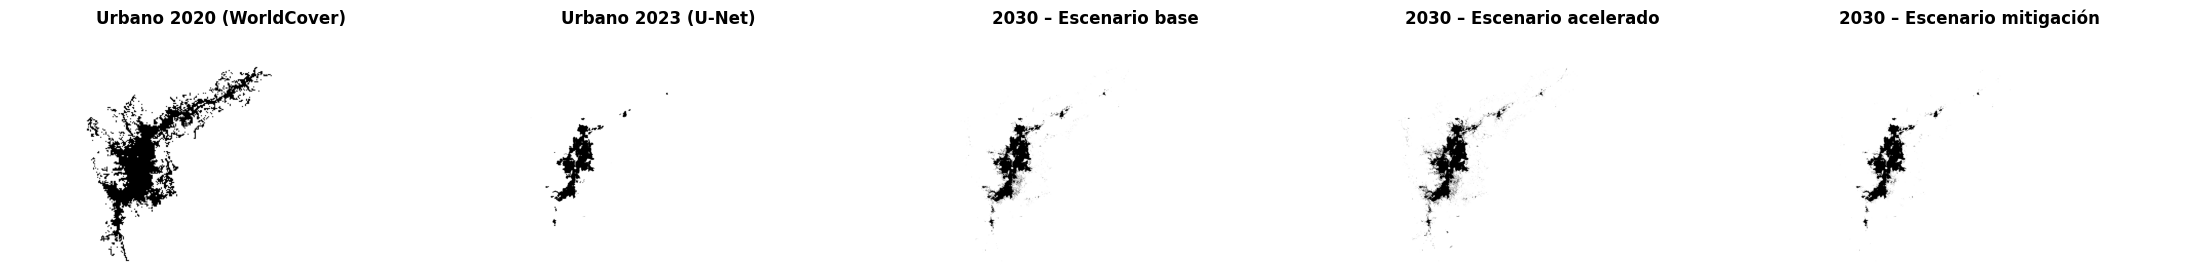

In [25]:

fig, axes = plt.subplots(1, 5, figsize=(22, 4))

titles = [
    "Urbano 2020 (WorldCover)",
    "Urbano 2023 (U-Net)",
    "2030 – Escenario base",
    "2030 – Escenario acelerado",
    "2030 – Escenario mitigación"
]

data_list = [u20, u23, urb_2030_base, urb_2030_acel, urb_2030_mitig]

for ax, data, title in zip(axes, data_list, titles):
    im = ax.imshow(data, cmap="gray_r", vmin=0, vmax=1)
    ax.set_title(title, fontweight="bold")
    ax.axis("off")

plt.tight_layout()
plt.show()


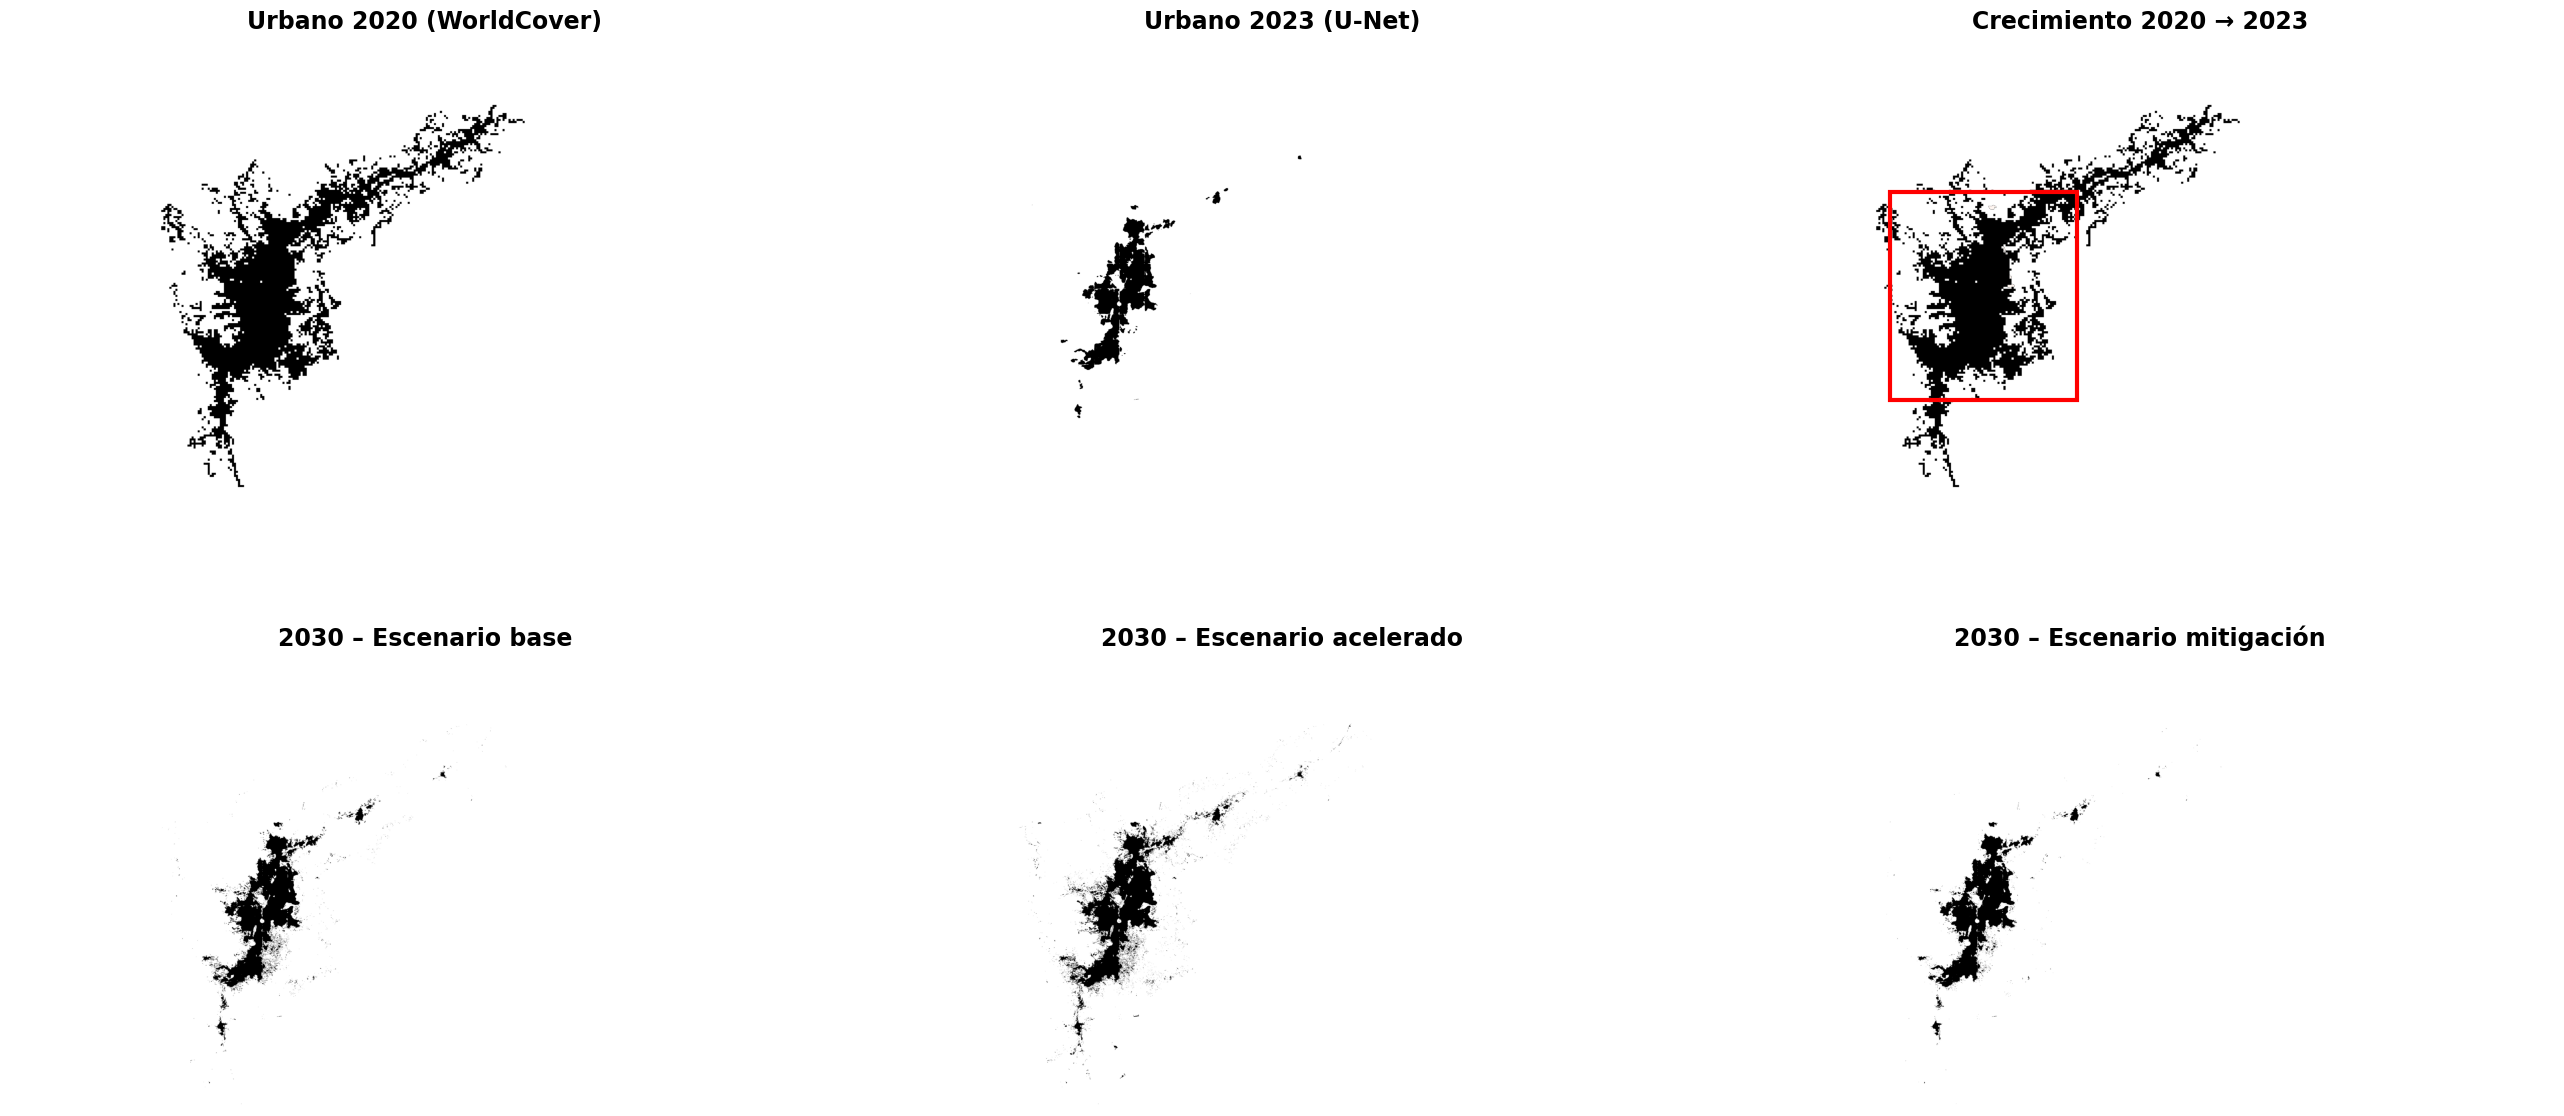

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

crecimiento = np.logical_and(u20 == 0, u23 == 1).astype(int)

fig, axes = plt.subplots(2, 3, figsize=(26, 14))

titles = [
    "Urbano 2020 (WorldCover)",
    "Urbano 2023 (U-Net)",
    "Crecimiento 2020 → 2023",
    "2030 – Escenario base",
    "2030 – Escenario acelerado",
    "2030 – Escenario mitigación"
]

datasets = [
    u20,
    u23,
    crecimiento,
    urb_2030_base,
    urb_2030_acel,
    urb_2030_mitig
]

for ax, data, title in zip(axes.flatten(), datasets, titles):
    if title == "Crecimiento 2020 → 2023":
        ax.imshow(u20, cmap="gray_r", vmin=0, vmax=1)
        ax.imshow(np.ma.masked_where(crecimiento==0, crecimiento),
                  cmap="Reds", alpha=0.9)
    else:
        ax.imshow(data, cmap="gray_r", vmin=0, vmax=1)

    ax.set_title(title, fontsize=17, fontweight="bold")
    ax.axis("off")

coords = np.column_stack(np.where(crecimiento == 1))

if len(coords) > 0:
    ymin, xmin = coords.min(axis=0)
    ymax, xmax = coords.max(axis=0)

    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=3,
        edgecolor='red',
        facecolor='none'
    )


    ax_growth = axes[0, 2]
    ax_growth.add_patch(rect)

plt.tight_layout(pad=2)


plt.savefig("panel_urbano_2x3_crecimiento.png", dpi=300, bbox_inches="tight")
plt.show()


In [27]:
u20
u23
urb_2030_base
urb_2030_acel
urb_2030_mitig


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

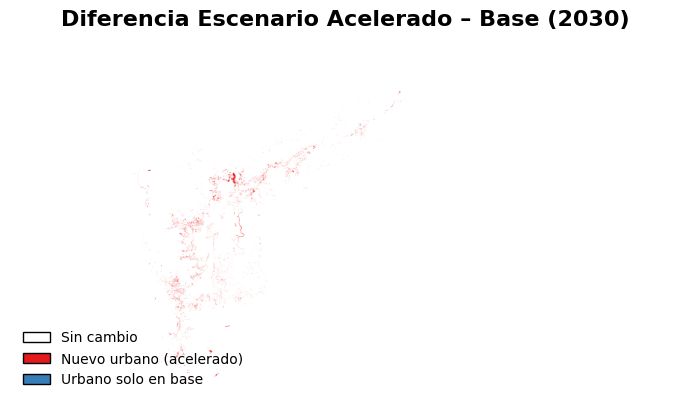

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


nuevo_acel   = np.logical_and(urb_2030_acel == 1, urb_2030_base == 0)
perdido_acel = np.logical_and(urb_2030_acel == 0, urb_2030_base == 1)


diff_acel = np.zeros_like(urb_2030_base, dtype=int)
diff_acel[nuevo_acel]   = 1
diff_acel[perdido_acel] = 2

cmap_acel = ListedColormap([
    "white",
    "#e41a1c",
    "#377eb8"
])

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(diff_acel, cmap=cmap_acel, vmin=0, vmax=2)
ax.set_title("Diferencia Escenario Acelerado – Base (2030)", fontsize=16, fontweight="bold")
ax.axis("off")


from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="white",   edgecolor="black", label="Sin cambio"),
    Patch(facecolor="#e41a1c", edgecolor="black", label="Nuevo urbano (acelerado)"),
    Patch(facecolor="#377eb8", edgecolor="black", label="Urbano solo en base"),
]
ax.legend(handles=legend_elements, loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("diferencia_2030_acelerado_base.png", dpi=300, bbox_inches="tight")
plt.show()
